### Evaluation and descriptive statistics
---------------------
Kilian Lüders & Bent Stohlmann

1.5.2023 (Draft Version)

This notebook contains all of the analysis, descriptive statistics, tables, and plots that can be found in the paper.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# metadata of GFCC decisions
metadata = pd.read_csv("data/Metadaten2.6.1.csv", sep="\t")
metadata = metadata.rename(columns={'dateiname': 'entscheidung'}) # uniform variable naming

# training data decision level
data_dec = pd.read_pickle("data/training_data.pkl")

### Description data set

In [6]:
# number of all decisions in the decision collection
metadata.shape[0]

10663

In [7]:
# selection of decisions that are in the target population.
metadata = metadata[metadata['jahr'] < 2021] # before 2021
metadata = metadata[metadata['inAS'] == 1] # in the official collection
metadata = metadata[metadata['gruende'] == 1] # has a justification
metadata = metadata[metadata['spruchkoerper'].isin(['I','II'])] # from one of the senates 

In [8]:
# number of decisions in the target population 
metadata.entscheidung.nunique()

3371

In [9]:
# number of annotated decisions
data_dec.entscheidung.nunique()

300

In [10]:
# equivalence of book pages in the official collection
metadata.merge(data_dec, on='entscheidung', how='right').apply(lambda row: row.letzteSeite - row.ersteSeite + 1, axis=1).sum().astype(int)

5739

### Description of the annotation

In [11]:
# Number of decisions with proportionality test
(data_dec.prop > 0).value_counts()

False    240
True      60
Name: prop, dtype: int64

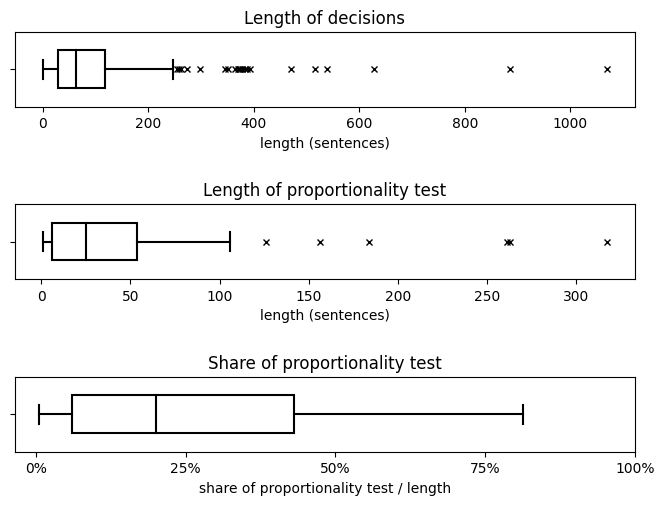

In [12]:
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops': {'marker':'x','markeredgecolor':'black'}
}

plt_df = data_dec[data_dec.prop > 0].copy()
plt_df['share'] = plt_df.apply(lambda row: row.prop / row.len, axis=1)

fig, axs = plt.subplots(nrows=3,figsize=(8, 7))

#fig.tight_layout(pad=5.0)
sns.boxplot(x = data_dec['len'], color='white', width=.5, **PROPS, ax=axs[0])
axs[0].set_title("Length of decisions")
axs[0].set_xlabel("length (sentences)")
sns.boxplot(x = plt_df['prop'], color='white', width=.5, **PROPS, ax=axs[1])
axs[1].set_title("Length of proportionality test")
axs[1].set_xlabel("length (sentences)")
sns.boxplot(x = plt_df['share'], color='white', width=.5, **PROPS, ax=axs[2])
axs[2].set_title("Share of proportionality test")
axs[2].set_xlabel("share of proportionality test / length")
axs[2].set_xticks([0,0.25,0.5,0.75,1],['0%','25%','50%','75%','100%'])

fig.subplots_adjust(bottom=0.2,
                    top=0.8,
                    hspace=1.3)
plt.show()

## Performance Tabels

### Dec Level Classification

In [15]:
metrics_dec = pd.read_csv("data/performance_data.csv", index_col=0).rename(columns={'info':'text'})
metrics_dec['feature'] = metrics_dec['feature'].fillna("")
metrics_dec['text'] = metrics_dec['text'].fillna("")
metrics_dec.head()

,model,feature,text,type,fold,tn,fp,fn,tp,precision_ind_0,precision_ind_1,precision_micro,recall_ind_0,recall_ind_1,recall_micro,fscore_ind_0,fscore_ind_1,fscore_mirco,loss
0,majority,,,dec,0,48,0,12,0,0.8,0.0,0.8,1.0,0.0,0.8,0.888889,0.0,0.8,NaN
1,majority,,,dec,1,48,0,12,0,0.8,0.0,0.8,1.0,0.0,0.8,0.888889,0.0,0.8,NaN
2,majority,,,dec,2,48,0,12,0,0.8,0.0,0.8,1.0,0.0,0.8,0.888889,0.0,0.8,NaN
3,majority,,,dec,3,48,0,12,0,0.8,0.0,0.8,1.0,0.0,0.8,0.888889,0.0,0.8,NaN
4,majority,,,dec,4,48,0,12,0,0.8,0.0,0.8,1.0,0.0,0.8,0.888889,0.0,0.8,NaN


In [16]:
metrics_dec_df = metrics_dec.groupby(['model','feature','text']).agg(
    precision_0 = pd.NamedAgg(column="precision_ind_0", aggfunc="mean"),
    precision_0_sd = pd.NamedAgg(column="precision_ind_0", aggfunc="std"),
    precision_1 = pd.NamedAgg(column="precision_ind_1", aggfunc="mean"),
    precision_1_sd = pd.NamedAgg(column="precision_ind_1", aggfunc="std"),
    recall_0 = pd.NamedAgg(column="recall_ind_0", aggfunc="mean"),
    recall_0_sd = pd.NamedAgg(column="recall_ind_0", aggfunc="std"),
    recall_1 = pd.NamedAgg(column="recall_ind_1", aggfunc="mean"),
    recall_1_sd = pd.NamedAgg(column="recall_ind_1", aggfunc="std"),
    fscore_0 = pd.NamedAgg(column="fscore_ind_0", aggfunc="mean"),
    fscore_0_sd = pd.NamedAgg(column="fscore_ind_0", aggfunc="std"),
    fscore_1 = pd.NamedAgg(column="fscore_ind_1", aggfunc="mean"),
    fscore_1_sd = pd.NamedAgg(column="fscore_ind_1", aggfunc="std"),
    precision_global = pd.NamedAgg(column="precision_micro", aggfunc="mean"),
    precision_global_sd = pd.NamedAgg(column="precision_micro", aggfunc="std"),
    recall_global = pd.NamedAgg(column="recall_micro", aggfunc="mean"),
    recall_global_sd = pd.NamedAgg(column="recall_micro", aggfunc="std"),
    fscore_global = pd.NamedAgg(column="fscore_mirco", aggfunc="mean"),
    fscore_global_sd = pd.NamedAgg(column="fscore_mirco", aggfunc="std")
)

output_kfold = pd.DataFrame()
output_kfold['precision'] = metrics_dec_df.apply(lambda row: "{:.3f} ({:.2f})".format(row['precision_global'], row['precision_global_sd']), axis=1)
output_kfold['recall'] = metrics_dec_df.apply(lambda row: "{:.3f} ({:.2f})".format(row['recall_global'], row['recall_global_sd']), axis=1)
output_kfold['fscore'] = metrics_dec_df.apply(lambda row: "{:.3f} ({:.2f})".format(row['fscore_global'], row['fscore_global_sd']), axis=1)

output_kfold['precision_ind'] = metrics_dec_df.apply(lambda row: "{:.3f} ({:.2f})".format(row['precision_1'], row['precision_1_sd']), axis=1)
output_kfold['recall_ind'] = metrics_dec_df.apply(lambda row: "{:.3f} ({:.2f})".format(row['recall_1'], row['recall_1_sd']), axis=1)
output_kfold['fscore_ind'] = metrics_dec_df.apply(lambda row: "{:.3f} ({:.2f})".format(row['fscore_1'], row['fscore_1_sd']), axis=1)

output_kfold.columns = pd.MultiIndex.from_tuples([("Global Metrics", "Precision"), ("Global Metrics", "Recall"), ("Global Metrics", "Fscore"),
                                                  ("Prediction Proportionality", "Precision"), ("Prediction Proportionality", "Recall"), ("Prediction Proportionality", "Fscore")], names=["", ""])

output_kfold.sort_index(ascending=False)

Global Metrics                              \
                              Precision        Recall        Fscore   
model      feature text                                               
rule based                 0.930 (0.02)  0.930 (0.02)  0.930 (0.02)   
majority                   0.800 (0.00)  0.800 (0.00)  0.800 (0.00)   
XGBoost    tfidf   token   0.903 (0.04)  0.903 (0.04)  0.903 (0.04)   
                   lemma   0.907 (0.05)  0.907 (0.05)  0.907 (0.05)   
           cv      token   0.883 (0.05)  0.883 (0.05)  0.883 (0.05)   
                   lemma   0.890 (0.04)  0.890 (0.04)  0.890 (0.04)   
           WE              0.843 (0.03)  0.843 (0.03)  0.843 (0.03)   
SVC        tfidf   token   0.800 (0.02)  0.800 (0.02)  0.800 (0.02)   
                   lemma   0.800 (0.00)  0.800 (0.00)  0.800 (0.00)   
           cv      token   0.793 (0.05)  0.793 (0.05)  0.793 (0.05)   
                   lemma   0.780 (0.04)  0.780 (0.04)  0.780 (0.04)   
           WE              0.800 (0.00)  0.800 (0.00)  0.800 (0.00)   
NN         tfidf   token   0.757 (0.04)  0.757 (0.04)  0.757 (0.04)   
                   lemma   0.723 (0.04)  0.723 (0.04)  0.723 (0.04)   
           cv      token   0.737 (0.05)  0.737 (0.05)  0.737 (0.05)   
                   lemma   0.710 (0.04)  0.710 (0.04)  0.710 (0.04)   
           WE              0.690 (0.04)  0.690 (0.04)  0.690 (0.04)   
LR         tfidf   token   0.840 (0.04)  0.840 (0.04)  0.840 (0.04)   
                   lemma   0.817 (0.02)  0.817 (0.02)  0.817 (0.02)   
           cv      token   0.820 (0.08)  0.820 (0.08)  0.820 (0.08)   
                   lemma   0.850 (0.07)  0.850 (0.07)  0.850 (0.07)   
           WE              0.853 (0.03)  0.853 (0.03)  0.853 (0.03)   

                         Prediction Proportionality                \
                                          Precision        Recall   
model      feature text                                             
rule based                             0.798 (0.07)  0.883 (0.11)   
majority                               0.000 (0.00)  0.000 (0.00)   
XGBoost    tfidf   token               0.947 (0.08)  0.550 (0.22)   
                   lemma               0.896 (0.19)  0.600 (0.20)   
           cv      token               0.831 (0.19)  0.533 (0.14)   
                   lemma               0.825 (0.13)  0.567 (0.19)   
           WE                          0.678 (0.10)  0.433 (0.18)   
SVC        tfidf   token               0.400 (0.55)  0.033 (0.05)   
                   lemma               0.000 (0.00)  0.000 (0.00)   
           cv      token               0.383 (0.36)  0.133 (0.13)   
                   lemma               0.180 (0.25)  0.067 (0.09)   
           WE                          0.000 (0.00)  0.000 (0.00)   
NN         tfidf   token               0.356 (0.12)  0.267 (0.09)   
                   lemma               0.244 (0.12)  0.183 (0.09)   
           cv      token               0.289 (0.17)  0.217 (0.13)   
                   lemma               0.200 (0.12)  0.150 (0.09)   
           WE                          0.133 (0.12)  0.100 (0.09)   
LR         tfidf   token               0.797 (0.25)  0.283 (0.13)   
                   lemma               0.867 (0.30)  0.117 (0.05)   
           cv      token               0.600 (0.33)  0.367 (0.21)   
                   lemma               0.744 (0.23)  0.450 (0.24)   
           WE                          0.833 (0.17)  0.333 (0.13)   

                                        
                                Fscore  
model      feature text                 
rule based                0.833 (0.05)  
majority                  0.000 (0.00)  
XGBoost    tfidf   token  0.674 (0.19)  
                   lemma  0.710 (0.18)  
           cv      token  0.644 (0.15)  
                   lemma  0.662 (0.16)  
           WE             0.507 (0.15)  
SVC        tfidf   token  0.062 (0.08)  
                   lemma  0.000 (0.00)  
           cv      token  0.195

In [19]:
output_kfold.sort_index(ascending=False).style.to_latex("fig/tab_1.tex")
output_kfold.sort_index(ascending=False).to_csv("fig/tab_1.csv")